# Predicting Electricity Consumption - Regression Model

The dataset used for this project is located here: https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata 
        
The goal of the project is to build a model that predicts the electricity consumption (the 'KWH' field). 

The following Regression models are applied in this project: RandomForestRegressor, DecisionTreeRegressor, ExtraTreeRegressor, and LinearRegression.  

During the preprocessing stage, the dimentionality reduction of features is conducted with Truncated SVD.

The performance of the Regression model can be improved if feature selection analysis is conducted more thouroughly, and NaN/missing values (these values were coded as '-2' in this dataset) are better handled. Due to the time limit, I had to spend little time on these two mentioned processes. 

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD

In [2]:
#Examine the raw dataset
data_files = pd.read_csv("recs2009_public.csv")
pd.set_option("display.max_columns", None)
data_files.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,METROMICRO,UR,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,BASEHEAT,BASEHT2,PCTBSTHT,BASECOOL,BASECL2,PCTBSTCL,BASEUSE,ATTIC,ATTICFIN,FINATTRMS,ATTCHEAT,ATTCHT2,PCTATTHT,ATTCCOOL,ATTCCL2,PCTATTCL,ATTICUSE,PRKGPLC1,SIZEOFGARAGE,GARGLOC,GARGHEAT,GARGCOOL,PRKGPLC2,SIZEOFDETACH,OUTLET,ZKOWNRENT,ZCONDCOOP,ZYEARMADE,ZYEARMADERANGE,ZOCCUPYYRANGE,ZCONVERSION,ZORIG1FAM,ZLOOKLIKE,ZNUMFLRS,ZNUMAPTS,ZWALLTYPE,ZROOFTYPE,ZSTUDIO,ZNAPTFLRS,ZSTORIES,ZTYPEHUQ4,ZBEDROOMS,ZNCOMBATH,ZNHAFBATH,ZOTHROOMS,ZCELLAR,ZCRAWL,ZCONCRETE,ZBASEFIN,ZFINBASERMS,ZBASEHEAT,ZBASEHT2,ZPCTBSTHT,ZBASECOOL,ZBASECL2,ZPCTBSTCL,ZBASEUSE,ZATTIC,ZATTICFIN,ZFINATTRMS,ZATTCHEAT,ZATTCHT2,ZPCTATTHT,ZATTCCOOL,ZPCTATTCL,ZATTCCL2,ZATTICUSE,ZPRKGPLC1,ZSIZEOFGARAGE,ZGARGLOC,ZGARGHEAT,ZGARGCOOL,ZPRKGPLC2,ZSIZEOFDETACH,STOVEN,STOVENFUEL,STOVE,STOVEFUEL,OVEN,OVENFUEL,OVENUSE,OVENCLN,TYPECLN,MICRO,AMTMICRO,DEFROST,OUTGRILL,OUTGRILLFUEL,TOPGRILL,STGRILA,TOASTER,NUMMEAL,FUELFOOD,COFFEE,NUMFRIG,TYPERFR1,SIZRFRI1,REFRIGT1,ICE,AGERFRI1,ESFRIG,REPLCFRI,HELPFRI,HELPFRIY,TYPERFR2,SIZRFRI2,REFRIGT2,MONRFRI2,AGERFRI2,ESFRIG2,TYPERFR3,SIZRFRI3,REFRIGT3,MONRFRI3,AGERFRI3,ESFRIG3,SEPFREEZ,NUMFREEZ,UPRTFRZR,SIZFREEZ,FREEZER,AGEFRZR,REPLCFRZ,HELPFRZ,HELPFRZY,UPRTFRZR2,SIZFREEZ2,FREEZER2,AGEFRZR2,DISHWASH,DWASHUSE,AGEDW,ESDISHW,REPLCDW,HELPDW,HELPDWY,ZSTOVEN,ZSTOVENFUEL,ZSTOVE,ZSTOVEFUEL,ZOVEN,ZOVENFUEL,ZOVENUSE,ZOVENCLN,ZTYPECLN,ZMICRO,ZAMTMICRO,ZDEFROST,ZOUTGRILL,ZOUTGRILLFUEL,ZTOPGRILL,ZSTGRILA,ZTOASTER,ZNUMMEAL,ZFUELFOOD,ZCOFFEE,ZNUMFRIG,ZTYPERFR1,ZSIZRFRI1,ZREFRIGT1,ZICE,ZAGERFRI1,ZTYPERFR2,ZSIZRFRI2,ZREFRIGT2,ZMONRFRI2,ZAGERFRI2,ZTYPERFR3,ZSIZRFRI3,ZREFRIGT3,ZMONRFRI3,ZAGERFRI3,ZSEPFREEZ,ZNUMFREEZ,ZUPRTFRZR,ZSIZFREEZ,ZFREEZER,ZAGEFRZR,ZUPRTFRZR2,ZSIZFREEZ2,ZFREEZER2,ZAGEFRZR2,ZDISHWASH,ZDWASHUSE,ZAGEDW,CWASHER,TOPFRONT,WASHLOAD,WASHTEMP,RNSETEMP,AGECWASH,ESCWASH,REPLCCW,HELPCW,HELPCWY,DRYER,DRYRFUEL,DRYRUSE,AGECDRYER,TVCOLOR,TVSIZE1,TVTYPE1,CABLESAT1,COMBODVR1,DVR1,DIGITSTB1,PLAYSTA1,COMBOVCRDVD1,VCR1,DVD1,TVAUDIOSYS1,OTHERSTB1,TVONWD1,TVONWDWATCH1,TVONWE1,TVONWEWATCH1,TVSIZE2,TVTYPE2,CABLESAT2,COMBODVR2,DVR2,DIGITSTB2,PLAYSTA2,COMBOVCRDVD2,VCR2,DVD2,TVAUDIOSYS2,OTHERSTB2,TVONWD2,TVONWDWATCH2,TVONWE2,TVONWEWATCH2,TVSIZE3,TVTYPE3,CABLESAT3,COMBODVR3,DVR3,DIGITSTB3,PLAYSTA3,COMBOVCRDVD3,VCR3,DVD3,TVAUDIOSYS3,OTHERSTB3,TVONWD3,TVONWDWATCH3,TVONWE3,TVONWEWATCH3,COMPUTER,NUMPC,PCTYPE1,MONITOR1,TIMEON1,PCONOFF1,PCSLEEP1,PCTYPE2,MONITOR2,TIMEON2,PCONOFF2,PCSLEEP2,PCTYPE3,MONITOR3,TIMEON3,PCONOFF3,PCSLEEP3,INTERNET,INDIALUP,INDSL,INCABLE,INSATEL,INWIRELESS,PCPRINT,FAX,COPIER,WELLPUMP,DIPSTICK,SWAMPCOL,AQUARIUM,STEREO,NOCORD,ANSMACH,BATTOOLS,BATCHRG,CHRGPLGT,ELECDEV,ELECCHRG,CHRGPLGE,ZCWASHER,ZTOPFRONT,ZWASHLOAD,ZWASHTEMP,ZRNSETEMP,ZAGECWASH,ZDRYER,ZDRYRFUEL,ZDRYRUSE,ZAGECDRYER,ZTVCOLOR,ZTVSIZE1,ZTVTYPE1,ZCABLESAT1,ZCOMBODVR1,ZDVR1,ZDIGITSTB1,ZPLAYSTA1,ZCOMBOVCRDVD1,ZVCR1,ZDVD1,ZTVAUDIOSYS1,ZOTHERSTB1,ZTVONWD1,ZTVONWDWATCH1,ZTVONWE1,ZTVONWEWATCH1,ZTVSIZE2,ZTVTYPE2,ZCABLESAT2,ZCOMBODVR2,ZDVR2,ZDIGITSTB2,ZPLAYSTA2,ZCOMBOVCRDVD2,ZVCR2,ZDVD2,ZTVAUDIOSYS2,ZOTHERSTB2,ZTVONWD2,ZTVONWDWATCH2,ZTVONWE2,ZTVONWEWATCH2,ZTVSIZE3,ZTVTYPE3,ZCABLESAT3,ZCOMBODVR3,ZDVR3,ZDIGITSTB3,ZPLAYSTA3,ZCOMBOVCRDVD3,ZVCR3,ZDVD3,ZTVAUDIOSYS3,ZOTHERSTB3,ZTVONWD3,ZTVONWDWATCH3,ZTVONWE3,ZTVONWEWATCH3,ZCOMPUTER,ZNUMPC,ZPCTYPE1,ZMONITOR1,ZTIMEON1,ZPCONOFF1,ZPCSLEEP1,ZPCTYPE2,ZMONITOR2,ZTIMEON2,ZPCONOFF2,ZPCSLEEP2,ZPCTYPE3,ZMONITOR3,ZTIMEON3,ZPCONOFF3,ZPCSLEEP3,ZINTERNET,ZINDIALUP,ZINDSL,ZINCABLE,ZINSATEL,ZINWIRELESS,ZPCPRINT,ZFAX,ZCOPIER,ZWELLPUMP,ZDIPSTICK,ZSWAMPCOL,ZAQUARIUM,ZSTEREO,ZNOCORD,ZANSMACH,ZBATTOOLS,ZBATCHRG,ZCHRGPLGT,ZELECDEV,ZELECCHRG,ZCHRGPLGE,HEATHOME,DNTHEAT,EQUIPNOHEAT,FUELNOHEAT,EQUIPM,FUELHEAT,MAINTHT,EQUIPAGE,REPLCHT,HE

In [3]:
#The following variables were selected to be used in the model. 
df_data = data_files[['DOEID', 'CDD30YR', 'BEDROOMS', 'TOTROOMS', 'FUELH2O','TOTSQFT', 'HDD50', 'KWH']]

# df_data.head(20)

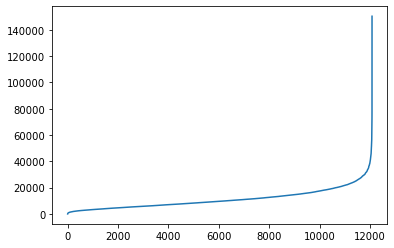

In [4]:
#Visualizing label - the 'KWH' field.
x_val = range(df_data.shape[0])
plt.plot(x_val,df_data['KWH'].sort_values())
plt.show()

In [5]:
#Replacing 'KWH' field with 'label' field
df_data['label']=df_data['KWH'].copy()
df_data[:5]

,DOEID,CDD30YR,BEDROOMS,TOTROOMS,FUELH2O,TOTSQFT,HDD50,KWH,label
0,1,1271,4,9,5,5075,2117,18466,18466
1,2,143,3,4,1,3136,62,5148,5148
2,3,829,1,2,1,528,2346,2218,2218
3,4,868,3,7,5,2023,2746,10015,10015
4,5,797,2,5,1,1912,2251,2869,2869


In [6]:
#Dropping KWH and DOEID fields
df_data.drop(['DOEID', 'KWH'],axis=1,inplace=True)
df_data[:5]

,CDD30YR,BEDROOMS,TOTROOMS,FUELH2O,TOTSQFT,HDD50,label
0,1271,4,9,5,5075,2117,18466
1,143,3,4,1,3136,62,5148
2,829,1,2,1,528,2346,2218
3,868,3,7,5,2023,2746,10015
4,797,2,5,1,1912,2251,2869


In [7]:
#Splitting into train and test sets
y = df_data['label']
X = df_data.drop('label',axis=1)
X.shape
X[:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

(12083, 6)

,CDD30YR,BEDROOMS,TOTROOMS,FUELH2O,TOTSQFT,HDD50
0,1271,4,9,5,5075,2117
1,143,3,4,1,3136,62
2,829,1,2,1,528,2346
3,868,3,7,5,2023,2746
4,797,2,5,1,1912,2251


Train (9666, 6) (9666,)
Test (2417, 6) (2417,)


In [8]:
#Function for Metrics
def train(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n') 
    return y_pred

# Dimentionality reduction with Truncated SVD
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

#Run 4 models to compare metrics
clf = LinearRegression()
print('Linear reg')
y_pred_lr = train(clf)
clf = RandomForestRegressor(max_depth= 5, max_features= 'sqrt', min_samples_split= 2, n_estimators = 5, random_state =42)
print('Random Forest')
y_pred_rf = train(clf)
clf = DecisionTreeRegressor(min_samples_split = 40, max_depth = 15, random_state =42)
print('Decision Tree')
y_pred_dt = train(clf)
clf = ExtraTreeRegressor(min_samples_leaf = 40, min_samples_split = 15, random_state=42)
print('Extra Tree')
y_pred_et = train(clf)


df_result = pd.DataFrame(y_test)
df_result['pred_lr'] = y_pred_lr.astype(int)
df_result['pred_rf'] = y_pred_rf.astype(int)
df_result['pred_dt'] = y_pred_dt.astype(int)
df_result['pred_et'] = y_pred_et.astype(int)


Linear reg
Mean Absolute Error: 4012.697119056491
Mean Squared Error: 30283301.804474223
Root Mean Squared Error: 5503.026604012943 

Random Forest
Mean Absolute Error: 4227.0400224931345
Mean Squared Error: 33598467.65867332
Root Mean Squared Error: 5796.418519971908 

Decision Tree
Mean Absolute Error: 4315.977585888648
Mean Squared Error: 37397978.15962607
Root Mean Squared Error: 6115.388635207583 

Extra Tree
Mean Absolute Error: 4100.490292564791
Mean Squared Error: 33077848.427888982
Root Mean Squared Error: 5751.334491045446 



In [9]:
df_result.sample(10)

,label,pred_lr,pred_rf,pred_dt,pred_et
10947,15556,14662,13726,17546,18591
8486,8258,9524,10313,10270,11785
10392,16647,19381,16426,14902,13452
6323,15834,15332,14917,21517,19681
2473,21321,11671,15995,6612,11059
6286,21455,17086,15995,20102,16753
5114,2710,7907,9417,7012,7024
6444,15297,14993,11229,14028,11778
9250,8781,7828,8838,9510,7049
11617,12903,10491,13271,24838,11025
